# HSNO isomerization IRC tutorial

This notebook illustrates energy, force, and NBO-derived descriptors for HSNO isomerization. It demonstrates how to interrogate charges and bond orders along the reaction coordinate; geometry editing and job submission are outside the present scope.

In [10]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
from kudi import IRCPath


def find_repo_root(start: Path | None = None) -> Path:
    here = (start or Path.cwd()).resolve()
    for parent in [here, *here.parents]:
        if (parent / "pyproject.toml").exists():
            return parent
    raise FileNotFoundError("Could not find repo root containing pyproject.toml")


repo_root = find_repo_root()
sys.path.insert(0, str(repo_root / "src"))
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True


def safe_series(values):
    return np.array([np.nan if v is None else v for v in values], dtype=float)


In [11]:
data_path = repo_root / "tests" / "fixtures" / "hsno_iso.dat"
irc_path = IRCPath.from_file(data_path)
rx = np.asarray(irc_path.rx_coords, dtype=float)
print(f"Loaded {len(irc_path.points)} IRC points from {data_path}")
has_nbo = any(p.nbo_charges or p.wiberg_bonds for p in irc_path.points)
print(f"NBO data detected: {has_nbo}")
first_geom = next((g for g in irc_path.geometries if g is not None), None)
atom_map = [(idx + 1, atom.symbol) for idx, atom in enumerate(first_geom.atoms)] if first_geom else []
print("Atom index map (1-based):", atom_map)


Loaded 91 IRC points from /home/svogt/repos/kudi/tests/fixtures/hsno_iso.dat
NBO data detected: True
Atom index map (1-based): [(1, 'H'), (2, 'S'), (3, 'N'), (4, 'O')]


In [12]:
energy_kcal = np.asarray(irc_path.relative_energies_kcal(), dtype=float)
force_data = irc_path.reaction_force()


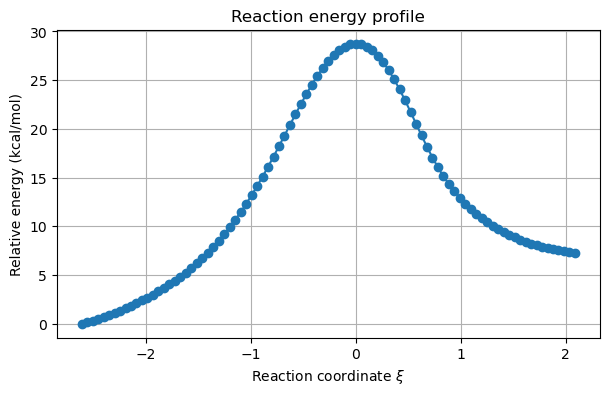

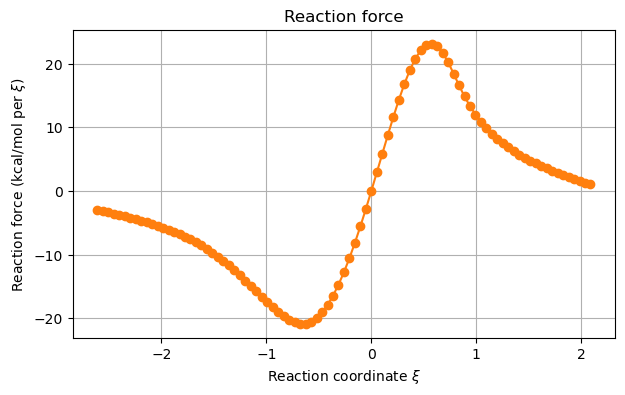

In [13]:
fig, ax = plt.subplots()
ax.plot(rx, energy_kcal, marker="o")
ax.set_xlabel(r"Reaction coordinate $\xi$")
ax.set_ylabel("Relative energy (kcal/mol)")
ax.set_title("Reaction energy profile")
plt.show()

fig, ax = plt.subplots()
ax.plot(force_data["reaction_coordinate"], force_data["reaction_force"], marker="o", color="C1")
ax.set_xlabel(r"Reaction coordinate $\xi$")
ax.set_ylabel("Reaction force (kcal/mol per $\\xi$)")
ax.set_title("Reaction force")
plt.show()


### NBO analysis along the IRC

We examine natural charges for the four atoms and Wiberg bond indices for the S–N and N–O bonds. Derivatives are evaluated with `numpy.gradient` to highlight where bonding changes fastest.

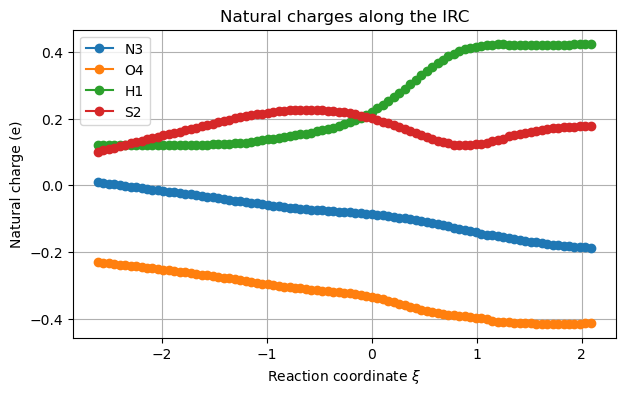

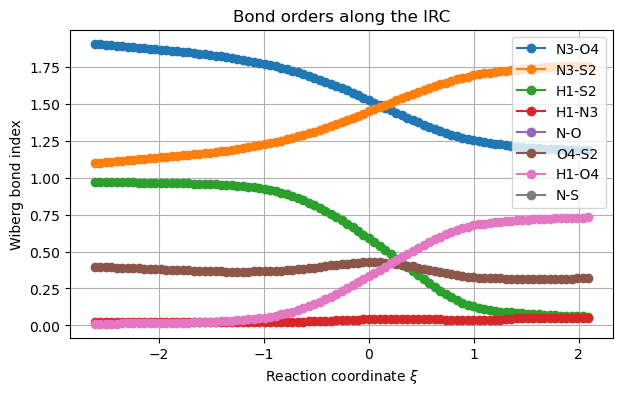

In [9]:
charge_labels = ["H1", "S2", "N3", "O4"]
charges = {label: safe_series(series) for label, series in irc_path.nbo_charges(charge_labels).items()}
bond_keys = ["N-S", "N-O"]
bond_orders = {key: safe_series(series) for key, series in irc_path.wiberg_bond_orders(bond_keys).items()}


fig, ax = plt.subplots()
for label, series in charges.items():
    ax.plot(rx, series, marker="o", label=label)
ax.set_xlabel(r"Reaction coordinate $\xi$")
ax.set_ylabel("Natural charge (e)")
ax.set_title("Natural charges along the IRC")
ax.legend()
plt.show()

fig, ax = plt.subplots()
for key, series in bond_orders.items():
    ax.plot(rx, series, marker="o", label=key)
ax.set_xlabel(r"Reaction coordinate $\xi$")
ax.set_ylabel("Wiberg bond index")
ax.set_title("Bond orders along the IRC")
ax.legend()
plt.show()


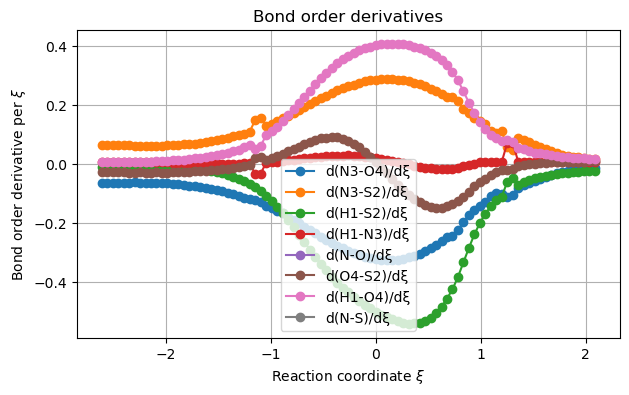

In [8]:
derivatives = {}
for key, series in bond_orders.items():
    derivatives[key] = np.gradient(series, rx)

fig, ax = plt.subplots()
for key, series in derivatives.items():
    ax.plot(rx, series, marker="o", label=f"d({key})/dξ")
ax.set_xlabel(r"Reaction coordinate $\xi$")
ax.set_ylabel(r"Bond order derivative per $\xi$")
ax.set_title("Bond order derivatives")
ax.legend()
plt.show()


### Interpretation notes

* The energy/force profile outlines the isomerization barrier and reveals where structural changes accelerate.
* Natural charge shifts track electron density redistribution, especially between sulfur, nitrogen, and oxygen.
* Wiberg bond indices reflect bond rearrangement; their derivatives emphasize the stages with the most rapid bonding change.
* Missing NBO entries (if any) are handled as NaN so plots render smoothly even with incomplete data.